# 3.2 Accessing MODIS Data products

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

## 3.2.1 Introduction

[[up to 3.0](Chapter3_1_GDAL.ipynb)]

In this section, you will learn how to:

* scan the directories (on the Earthdata server) where the MODIS data are stored
* get the dataset filename for a given tile, date and product
* get to URL associated with the dataset
* use the URL to pull the dataset over to store in the local file system

You should already know:

* basic use of Python (sections 1 and 2)
* the MODIS product grid system
* the two tiles needed to cover the UK 

        tiles = ['h17v03', 'h18v03']
        
* what LAI is and the code for the MODIS LAI/FPAR product [MOD15](https://modis.gsfc.nasa.gov/data/dataprod/mod15.php)
* your username and password for [NASA Earthdata](https://urs.earthdata.nasa.gov/home), or have previously entered this with [`cylog`](geog0111/cylog.py).

Let's first just test your NASA login:

In [ ]:
import geog0111.nasa_requests as nasa_requests
from geog0111.cylog import cylog

url = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/' 
        
# grab the HTML information
try:
    html = nasa_requests.get(url).text
    # test a few lines of the html
    if html[:20] == '<!DOCTYPE HTML PUBLI':
        print('this seems to be ok ... ')
        print('use cylog().login() anywhere you need to specify the tuple (username,password)')
except:
    print('login error ... try entering your username password again')
    print('then re-run this cell until it works')
    cylog(init=True)

We use the local class `geog0111.nrequests` here, in place of the usual `requests` as this lets the user avoid exposure to some of the tricky bits of getting data from the NASA server.


## 3.2.2  Accessing NASA MODIS URLs

Although you can access MODIS datasets through the [NASA Earthdata](https://urs.earthdata.nasa.gov/home) interface, there are many occasions that we would want to just automatically pull datasets. This is particularly true when you want a time series of data that might involve many files. For example, for analysing LAI or other variables over space/time) we will want to write code that pulls the time series of data. 

This is also something you will need to do the your assessed practical.

If the data we want to use are accessible to us as a URL, we can simply use `requests` as in previous exercises.

Sometimes, we will be able to specify the parameters of the dataset we want, e.g. using [JSON](https://www.json.org). At othertimes (as in the case here) we might need to do a little work ourselves to construct the particular URL we want.

If you visit the site [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006), you will see 'date' style links (e.g. `2018.09.30`) through to sub-directories. 

In these, e.g. [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/) you will find URLs of a set of files. 

The files pointed to by the URLs are the MODIS MOD15 4-day composite 500 m LAI/FPAR product [MCD15A3H](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd15a3h_v006).

There are links to several datasets on the page, including 'quicklook files' that are jpeg format images of the datasets, e.g.:

![MCD15A3H.A2018273.h17v03](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/BROWSE.MCD15A3H.A2018273.h17v03.006.2018278143630.1.jpg)

as well as `xml` files and `hdf` datasets. 



## 3.2.2.1 `datetime`

The URL we have used above, [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/) starts with a call to the server directory `MOTA`, so we can think of `https://e4ftl01.cr.usgs.gov/MOTA` asd the base level URL.

The rest of the directoy information `MCD15A3H.006/2018.09.30` tells us:

* the product name `MCD15A3H`
* the product version `006`
* the date of the dataset `2018.09.30`

There are several ways we could specify the date information. The most 'human readable' is probably `YYYY.MM.DD` as given here. 

Sometimes we will want to refer to it by 'day of year' (`doy`) (sometimes mistakenly referred to as [Julian day](https://en.wikipedia.org/wiki/Julian_day)) for a particular year. Day of year will be an integer that goes from 1 to 365 or 366 (inclusive).

We can use the Python `datetime` to do this:

import datetime

year = 2018

for doy in [1,60,365,366]:
    # set it up as Jan 1st, plus doy - 1
    d = datetime.datetime(year,1,1) + datetime.timedelta(doy-1)
    
    # note the careful formatting to include zeros in datestr
    datestr = f'{d.year:4d}.{d.month:02d}.{d.day:02d}'

    print(f'doy {doy:3d} in {year} is {datestr}')

**Exercise 3.2.1**

* copy the above code, and change the year to a leap year to see if it works as expected
* write some code that loops over each day in the year and converts from `doy` to the format of `datestr` above.
* modify the code so that it forms the full directory URL for the MODIS dataset, e.g. ` https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/` for each `doy`
* use what you have learned to write a function called `get_url()`, which you give the year and day of year and which returns the full URL. It should use keywords to define `product`, `version` and `base_url`. 
* For homework, tidy up your function, making sure you document it properly. Think aboiut what might happen if you enter incorrect information.

**Hint**: 
    
1. number of days in year
    
    ndays_in_year = (datetime.datetime(year,12,31) - datetime.datetime(year,1,1)).days + 1
    
Remember that `doy` goes from 1 to 365 or 366 (inclusive).

2. `datestr` format

We use `datestr = f'{d.year:4d}.{d.month:02d}.{d.day:02d}'` as the date string format. The elements such as `{d.year:4d}` mean that `d.year` is interpreted as an integer (`d`) of length `4`. When we put a `0` in front, such as in `02d` the resultant string is 'padded' with `0`. Try something like:

    value = 10
    print(f'{value:X10f}')

3. some bigger hints ...

To get the full URL, you will probably want to define something along the lines of:
    
    url = f'{base_url}/{product}.{version:03d}/{datestr}'
    
assuming version is an integer.

In [7]:
# do exercise here
# ANSWERS

import datetime
# leap year
# so we expect Dec 31st is doy 366
year = 2004
for doy in [1,60,365,366]:
# set it up as Jan 1st, plus doy - 1
    d = datetime.datetime(year,1,1) + datetime.timedelta(doy-1)

    # note the careful formatting to include zeros in datestr
    datestr = f'{d.year:4d}.{d.month:02d}.{d.day:02d}'
    filestr = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/' + datestr
    print(f'doy {doy:3d} in {year} is {filestr}')
    
    
def get_url(year,doy,basestr='https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/'):
    '''
    which you give the year and day of year and which returns the full URL. 
    It should use keywords to define product, version and base_url
    '''
    d = datetime.datetime(year,1,1) + datetime.timedelta(doy-1)
    datestr = f'{d.year:4d}.{d.month:02d}.{d.day:02d}'
    filestr = basestr + datestr
    return(filestr)

print(get_url(2000,1))

doy   1 in 2004 is https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2004.01.01
doy  60 in 2004 is https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2004.02.29
doy 365 in 2004 is https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2004.12.30
doy 366 in 2004 is https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2004.12.31
https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2000.01.01


### 3.2.2.2 html

When we access this 'listing' (directory links such as [https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/](https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/)) from Python, we will obtain the information in [HTML](https://www.w3schools.com/html/). We don't expect you to know this language in any great depth, but knowing some of the basics is oftem useful.

In [ ]:
import geog0111.nasa_requests as nasa_requests
from geog0111.get_url import get_url
import datetime

doy,year = 273,2018
# use your get_url function
# or the one supplied in geog0111
url = get_url(doy,year).url
print(url)

# pull the html
html = nasa_requests.get(url).text

# print a few lines of the html
print(html[:951])
# etc
print('\n','-'*30,'etc','-'*30)
# at the end
print(html[-964:])

https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30


In HTML the code text such as: 

    <a href="MCD15A3H.A2018273.h35v10.006.2018278143650.hdf">MCD15A3H.A2018273.h35v10.006.2018278143650.hdf</a>  


specifies an HTML link, that will appear as 

    MCD15A3H.A2018273.h35v10.006.2018278143650.hdf 2018-10-05 09:42  7.6K 
    
and link to the URL specified in the `href` field: `MCD15A3H.A2018273.h35v10.006.2018278143650.hdf`.

We could interpret this information by searching for strings etc., but the package `BeautifulSoup` can help us a lot in this.


 

In [5]:
import geog0111.nasa_requests as nasa_requests
from geog0111.get_url import get_url
from bs4 import BeautifulSoup

doy,year = 273,2018
url = get_url(doy,year).url
html = nasa_requests.get(url).text

# use BeautifulSoup
# to get all urls referenced with
# html code <a href="some_url">
soup = BeautifulSoup(html,'lxml')
links = [mylink.attrs['href'] for mylink in soup.find_all('a')]

**Exercise E3.2.2**

* copy the code in the block above and print out some of the linformation in the list `links` (e.g. the last 20 entries)
* using an implicit loop, make a list called `hdf_filenames` of only those filenames (links) that have `hdf` as their filename extension.

**Hint 1**: first you might select an example item from the `links` list: 

    item = links[-1]
    print('item is',item)
    
and print:

    item[-3:]
        
but maybe better (why would this be?) is:

    item.split('.')[-1]
    
**Hint 2**: An implicit loop is a construct of the form:

    [item for item in links]

In an implicit for loop, we can actually add a conditional statement if we like, e.g. try:

    hdf_filenames = [item for item in links if item[-5] == '4']
    
This will print out `item` if the condition `item[-5] == '4'` is met. That's a bit of a pointless test, but illustrates the pattern required. Try this now with the condition you want to use to select `hdf` files.

In [6]:
# do exercise here
# ANSWER

import geog0111.nasa_requests as nasa_requests
from geog0111.get_url import get_url
from bs4 import BeautifulSoup

doy,year = 273,2018
url = get_url(doy,year).url
html = nasa_requests.get(url).text

# use BeautifulSoup
# to get all urls referenced with
# html code <a href="some_url">
soup = BeautifulSoup(html,'lxml')
links = [mylink.attrs['href'] for mylink in soup.find_all('a')]
print(links[-20:])

hdfs = [mylink.attrs['href'] for mylink in soup.find_all('a') if mylink.attrs['href'].split('.')[-1] == 'hdf']
print(hdfs[-20:])

## 3.2.3 MODIS filename format

The `hdf` filenames are of the form:

    MCD15A3H.A2018273.h35v10.006.2018278143650.hdf
    
where:

* the first field (`MCD15A3H`) gives the product code
* the second (`A2018273`) gives the observation date: day of year `273`, `2018` here
* the third (`h35v10`) gives the 'MODIS tile' code for the data location
* the remaining fields specify the product version number (`006`) and a code representing the processing date.

If we want a particular dataset, we would assume then that we know the information to construct the first four fields.

We then have the task remaining of finding an address of the pattern:

    MCD15A3H.A2018273.h17v03.006.*.hdf
    
where `*` represents a wildcard (unknown element of the URL/filename).

Putting together the code from above to get a list of the `hdf` files:

In [7]:
#from geog0111.nasa_requests import nasa_requests
from bs4 import BeautifulSoup
from geog0111.get_url import get_url
import geog0111.nasa_requests as nasa_requests

doy,year = 273,2018
url = get_url(doy,year).url
html = nasa_requests.get(url).text
soup = BeautifulSoup(html,'lxml')
links = [mylink.attrs['href'] for mylink in soup.find_all('a')]

# get all files that end 'hdf' as in example above
hdf_filenames = [item for item in links if item.split('.')[-1] == 'hdf']

We now want to specify a particular tile or tiles to access.

In this case, we want to look at the field `item.split('.')[-4]` and check to see if it is the list `tiles`.

**Exercise 3.2.3**

* copy the code above and print out the first 10 values in the list `hdf_filenames`. Can you recognise where the tile information is in the string?

Now, let's check what we get when we look at `item.split('.')[-4]`.

* set a variable called `tiles` containing the names of the UK tiles (as in Exercise 3.1.1)
* write a loop `for item in links:` to loop over each item in the list `links`
* inside this loop set the condition `if item.split('.')[-1] == 'hdf':` to select only `hdf` files, as above
* inside this conditional statement, print out `item.split('.')[-4]` to see if it looks like the tile names
* having confirmed that you are getting the right information, add another conditional statement to see if `item.split('.')[-4] in tiles`, and then print only those filenames that pass both of your tests
* see if you can combine the two tests (the two `if` statements) into a single one

**Hint 1**: if you print all of the tilenames, this will go on for quite some time. Instead it may be better to use `print(item.split('.')[-4],end=' ')`, which will put a space, rather than a newline between each item printed.

**Hint 2**: recall what the logical statement `(A and B)` gives when thinking about the combined `if` statement

In [8]:
# do exercise here
# ANSWER
hdf_filenames = [item for item in links if item.split('.')[-1] == 'hdf']
print hdf_filenames[-20:]



You should end up with something like:

In [9]:
import geog0111.nasa_requests as nasa_requests
from bs4 import BeautifulSoup
from geog0111.get_url import get_url

doy,year = 273,2018
tiles = ['h17v03', 'h18v03']

url = get_url(doy,year).url
html = nasa_requests.get(url).text
soup = BeautifulSoup(html,'lxml')
links = [mylink.attrs['href'] for mylink in soup.find_all('a')]

tile_filenames = [item for item in links \
                      if (item.split('.')[-1] == 'hdf') and \
                         (item.split('.')[-4] in tiles)]

**Exercise E3.2.4**

* print out the first 10 items in `tile_filenames` and check the result is as you expect.
* write a function called `modis_tiles()` that takes as input `doy`, `year` and `tiles` and returns a list of the modis tile **urls**.

**Hint** 

1. Don't forget to put in a mechanism to allow you to change the default `base_url`, `product` and `version` (as you did for the function `get_url()`)

2. In some circumstances, yopu can get repeats of filenames in the list. One way to get around this is to convert the list to a `numpy` array, and use [`np.unique()`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.unique.html) to remove duplicates.

        import numpy as np
        tile_filenames = np.unique(tile_filenames)

In [10]:
# do exercise here

You should end up with something like:

In [11]:
from geog0111.modis_tiles import modis_tiles

doy,year = 273,2018
tiles = ['h17v03', 'h18v03']

tile_urls = modis_tiles(doy,year,tiles)

**Exercise E3.2.5**

* print out the first 10 items in `tile_urls` and check the result is as you expect.

In [12]:
# do exercise here

## 3.2.4 Saving binary data to a file

We suppose that we want to save the dataset to a local file on the system.

To do that, we need to know how to save a binary dataset to a file. To do this well, we should also consider factors such as whether we want to save a file we already have. 

Before we go any further we should check:

* that the directory exists (if not, create it)
* that the file doesn't already exist (else, don't bother)

We can conveniently use methods in [`pathlib.Path`](https://docs.python.org/3/library/pathlib.html) for this.

So, import `Path`:

    from pathlib import Path

We suppose we might want to put a file (variable `filename`) into the directory `destination_folder`:

To test if a directory exists and create if not:

    dest_path = Path(destination_folder)
    if not dest_path.exists():
        dest_path.mkdir()
        
To make a compound name of `dest_path` and `filename`:

    output_fname = dest_path.joinpath(filename)
        
To test if a file exists:

    if not output_fname.exists():
        print(f"{str(output_fname))} doesn't exist yet ..."})
        
    

**Exercise E3.2.6**

* set a variable `destination_folder` to `data` and write code to create this folder ('directory') if it doesn't already exist.
* set a variable `filename` to `test.bin` and write code to check to see if this file is in the folder `destination_folder`. If not, print a message to say so.

In [13]:
# do exercise here

We now try to read the binary file `data/test_image.bin`.

This involves opening a binary file for reading:

    fp = open(input_fname, 'rb')
    
Then reading the data:

    data = fp.read()
    
Then close `fp`

    fp.close()

In [14]:
input_fname = 'data/test_image.bin'
fp = open(input_fname, 'rb')
data = fp.read()
fp.close()
print(f'data read is {len(data)} bytes')

data read is 9136806 bytes


And now, write the data as `data/test.bin`.

This involves opening a binary file for writing:

    fp = open(output_fname, 'wb')
    
Then reading the data:

    d = fp.write(data)
    
and closing as before:

    fp.close()

In [15]:
output_fname = 'data/test.bin'
fp = open(output_fname, 'wb')
d = fp.write(data)
print(f'data written is {d} bytes')

data written is 9136806 bytes


We can avoid the need for the `close` by using the construct:

    with open(output_fname, 'wb') as fp:
        d = fp.write(data)

In [16]:
d = 0
with open(output_fname, 'wb') as fp:
    d = fp.write(data)
print(f'data written is {d} bytes')

data written is 9136806 bytes


**Exercise E3.2.7**

With the ideas above, write some code to:

* check to see if the output directory `data` exists
* if not, create it
* check to see if the input file `data/test_image.bin` exists
* if so, read it in to `data`
* check to see if the output file `data/test.bin` exists
* if not (and if you read data), save `data` to this file
* once you are happy with the code operation, write a function: `save_data(data,filename,destination_folder)` that takes the binary dataset `data` and writes it to the file `filename` in directory `destination_folder`. It should return the n umber of bytes written, and should check to see if files / directories exist and act accordingly.
* add a keyword option to `save_data()` that will overwrite the filename, even if it already exists.

In [17]:
# do exercise here

You should now know how to save a binary data file.

## 3.2.4 downloading the data file

The following code uses the `nasa_requests` library to pull some binary data from a URL.

The response is tested (`r.ok`), and if it is ok, then we split the url to derive the filename, and print this out.

The binary dataset is available as `r.content`, which we store to the variable `data` here:

In [18]:
import geog0111.nasa_requests as nasa_requests
from geog0111.modis_tiles import modis_tiles
from pathlib import Path

doy,year = 273,2018
tiles = ['h17v03', 'h18v03']
destination_folder = 'data'

tile_urls = modis_tiles(doy,year,tiles)

# loop over urls
for url in tile_urls:
    r = nasa_requests.get(url)
    
    # check response
    if r.ok:
        # get the filename from the url
        filename = url.split('/')[-1]
        # get the binary data
        data = r.content
        
        print(filename)
    else:
        print (f'response from {url} not good')

MCD15A3H.A2018273.h17v03.006.2018278143630.hdf
MCD15A3H.A2018273.h18v03.006.2018278143633.hdf


**Exercise E3.2.8**

* use the code above to write a function `get_modis_files()` that takes as input `doy`, `year` and `tiles`, has a default `destination_folder` of `data`, that downloads the appropriate datasets (if they don't already exist). It should have similar defaults to `modis_tiles()`. It should return a list of the output filenames.

In [19]:
# do exercise here

You should end up with something like:

In [20]:
import geog0111.nasa_requests as nasa_requests
from geog0111.save_data import save_data

doy,year = 273,2018
tiles = ['h17v03', 'h18v03']
destination_folder = 'data'

tile_urls = modis_tiles(doy,year,tiles)

# loop over urls
for url in tile_urls:
    r = nasa_requests.get(url)
    
    # check response
    if r.ok:
        # get the filename from the url
        filename = url.split('/')[-1]
        # get the binary data
        d = save_data(r.content,filename,destination_folder)
        print(filename,d)
    else:
        print (f'response from {url} not good')

MCD15A3H.A2018273.h17v03.006.2018278143630.hdf 0
MCD15A3H.A2018273.h18v03.006.2018278143633.hdf 0


## 3.2.5 Visualisation

We will learn more fully how to visualise these later, but just to show that the datasets exist.

You might want to look at the [FIPS](https://en.wikipedia.org/wiki/List_of_FIPS_country_codes) country codes for selecting boundary data.

In [21]:
import requests
import shutil 
'''
Get the world borders shapefile that we will need
'''
tm_borders_url = "http://thematicmapping.org/downloads/TM_WORLD_BORDERS-0.3.zip"

r = requests.get(tm_borders_url)
with open("data/TM_WORLD_BORDERS-0.3.zip", 'wb') as fp:
    fp.write (r.content)

shutil.unpack_archive("data/TM_WORLD_BORDERS-0.3.zip",
                     extract_dir="data/")

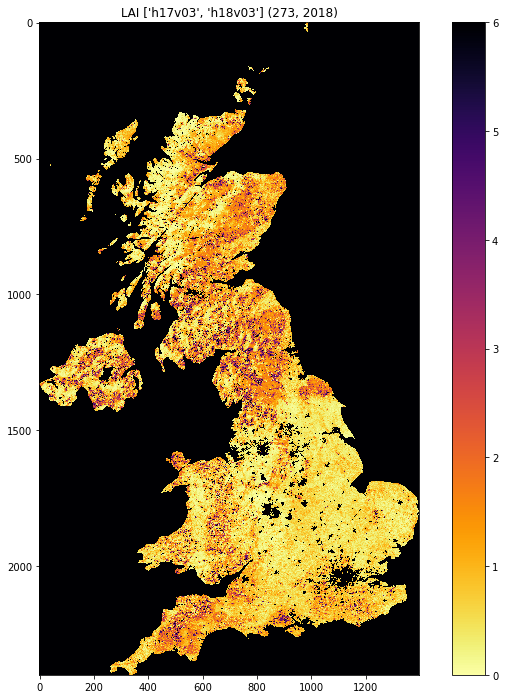

In [25]:
from geog0111.get_modis_files import get_modis_files
import gdal
import matplotlib.pylab as plt
import numpy as np

def mosaic_and_mask_data(gdal_fnames, vector_file, vector_where):
    stitch_vrt = gdal.BuildVRT("", gdal_fnames)
    g = gdal.Warp("", stitch_vrt,
                 format = 'MEM', dstNodata=200,
                  cutlineDSName = vector_file,
                  cutlineWhere = vector_where)
    return g

doy,year = 273,2018
tiles = ['h17v03', 'h18v03']
destination_folder = 'data'

filenames = get_modis_files(doy,year,tiles,base_url='https://e4ftl01.cr.usgs.gov/MOTA',\
                                           version=6,\
                                           product='MCD15A3H')

# this part is to access a particular dataset in the file
gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in filenames]


g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='UK'")

lai = np.array(g.ReadAsArray()).astype(float) * 0.1 # for LAI scaling
# valid data mask
mask = np.nonzero(lai < 20)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

lai = lai[min_y:max_y,
               min_x:max_x]

fig = plt.figure(figsize=(12,12))
im = plt.imshow(lai, interpolation="nearest", vmin=0, vmax=6,
             cmap=plt.cm.inferno_r)
plt.title('LAI'+' '+str(tiles)+' '+str((doy,year)))
plt.colorbar()

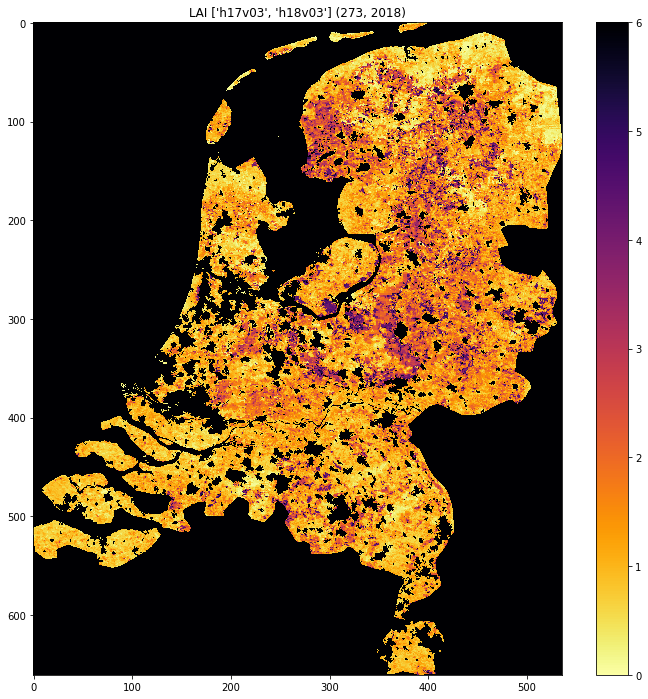

In [23]:
from geog0111.get_modis_files import get_modis_files
import gdal
import matplotlib.pylab as plt
import numpy as np

def mosaic_and_mask_data(gdal_fnames, vector_file, vector_where):
    stitch_vrt = gdal.BuildVRT("", gdal_fnames)
    g = gdal.Warp("", stitch_vrt,
                 format = 'MEM', dstNodata=200,
                  cutlineDSName = vector_file,
                  cutlineWhere = vector_where)
    return g

doy,year = 273,2018
tiles = ['h17v03', 'h18v03']
destination_folder = 'data'

filenames = get_modis_files(doy,year,tiles,base_url='https://e4ftl01.cr.usgs.gov/MOTA',\
                                           version=6,\
                                           product='MCD15A3H')

# this part is to access a particular dataset in the file
gdal_fnames = [f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_MCD15A3H:Lai_500m'
               for file_name in filenames]

g = mosaic_and_mask_data(gdal_fnames, "data/TM_WORLD_BORDERS-0.3.shp",
                         "FIPS='NL'")

lai = np.array(g.ReadAsArray()).astype(float) * 0.1 # for LAI scaling
# valid data mask
mask = np.nonzero(lai < 20)
min_y = mask[0].min()
max_y = mask[0].max() + 1

min_x = mask[1].min()
max_x = mask[1].max() + 1

lai = lai[min_y:max_y,
               min_x:max_x]

fig = plt.figure(figsize=(12,12))
im = plt.imshow(lai, interpolation="nearest", vmin=0, vmax=6,
             cmap=plt.cm.inferno_r)
plt.title('LAI'+' '+str(tiles)+' '+str((doy,year)))
plt.colorbar()

**Exercise 3.2.7 Homework**



* Have a look at the information for [`MOD10A1` product](http://www.icess.ucsb.edu/modis/SnowUsrGuide/usrguide_1dtil.html), which is the 500 m MODIS daily snow cover product.
* Use what you have learned here to download the MOD10A product over the UK

**Hint**: 
* The data are on a different server `https://n5eil01u.ecs.nsidc.org/MOST` 
* the template for the snow cover dataxset is `f'HDF4_EOS:EOS_GRID:"{file_name:s}":MOD_Grid_Snow_500m:NDSI_Snow_Cover'`
* today-10 may not be the best example doy: choose something in winter
* valid snow cover values are 0 to 100 (use this to set `vmin=0, vmax=100` when plotting)

**N.B. You will be required to download this dataset for your assessed practical, so it is a good idea to sort code for this now**

In [24]:
# do exercise here

## 3.2.6 Summary

In this session, we have learned how to download MODIS datasets from NASA Earthdata. 

We have developed and tested functions that group together the commands we want, ultimately arriving at the function `get_modis_files(doy,year,tiles,**kwargs)`.

We have seen ((if you've done the homework) that such code is re-useable and can directly be used for your assessed practical.